In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys
import torch

from sklearn.model_selection import train_test_split
sys.path.append("aav/util")

# The canonical single-letter code residue alphabet.
RESIDUES = tuple('ACDEFGHIKLMNPQRSTVWY')

# The AAV serotype 2 wild type subsequence corresponding to positions 561 to 588
R1_TILE21_WT_SEQ = 'DEEEIRTTNPVATEQYGSVSTNLQRGNR'

In [2]:
from sklearn.model_selection import train_test_split
from residue_encoding import ResidueIdentityEncoder
from mutation_encoding import MutationSequenceEncoder
from tqdm import tqdm
from aav.util import config


res_encoder = ResidueIdentityEncoder(alphabet=RESIDUES)
mut_encoder = MutationSequenceEncoder(res_encoder, R1_TILE21_WT_SEQ)

df = pd.read_csv("stat_195_project_data.csv")
df = df[df['partition'] != 'stop'].reset_index()
sequences = []
mutation_encoder = MutationSequenceEncoder(
    ResidueIdentityEncoder(config.RESIDUES),
    config.R1_TILE21_WT_SEQ
)
for i, row in tqdm(df.iterrows()):
    seq = row['sequence']
    np_seq = mutation_encoder.encode(seq).astype(np.float32)
    sequences.append(np_seq.reshape(1, -1))

sequences = np.concatenate(sequences, axis=0)
train_set, test_set = train_test_split(df, test_size=0.2)
X_train, y_train = sequences[train_set.index.values], train_set['is_viable'].values
X_test, y_test = sequences[test_set.index.values], test_set['is_viable'].values
print(len(X_train), len(y_train), len(X_test), len(y_test))

296913it [00:47, 6305.24it/s]


237530 237530 59383 59383


In [4]:
from aav.stat195_pytorch_work.torch_cnn_lassonet import CNNLassoNetClassifier

clf_cnn_lasso = CNNLassoNetClassifier(
    M=1,
    batch_size=512,
    n_iters=(30, 10),
    lambda_start=1,
    path_multiplier=1.1
)
path = clf_cnn_lasso.path(X_train, y_train)

Iteration 54 - Lambda: 171.87194770116255, selected_count: 1: : 54it [28:54, 32.11s/it] 


In [5]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

n_selected = []
accuracy = []
lambda_ = []

for save in path:
    clf_cnn_lasso.load(save.state_dict)
    y_pred = clf_cnn_lasso.predict(X_test)
    # print(y_pred)
    n_selected.append(save.selected.sum())
    accuracy.append(accuracy_score(y_test, y_pred))
    lambda_.append(save.lambda_)

In [6]:
print(max(accuracy))

0.9480827846353334


Text(0, 0.5, 'number of selected features')

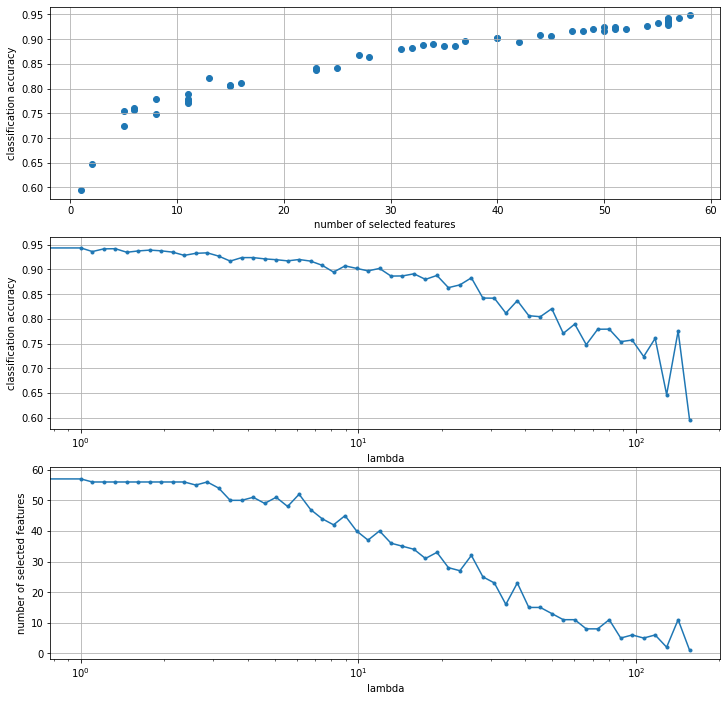

In [7]:
fig = plt.figure(figsize=(12, 12))

plt.subplot(311)
plt.grid(True)
plt.scatter(list(map(lambda x: x.item(), n_selected)), accuracy)
plt.xlabel("number of selected features")
plt.ylabel("classification accuracy")

plt.subplot(312)
plt.grid(True)
plt.plot(lambda_, accuracy, ".-")
plt.xlabel("lambda")
plt.xscale("log")
plt.ylabel("classification accuracy")

plt.subplot(313)
plt.grid(True)
plt.plot(lambda_, n_selected, ".-")
plt.xlabel("lambda")
plt.xscale("log")
plt.ylabel("number of selected features")

In [ ]:
from aav.stat195_pytorch_work.torch_cnn_lassonet import CNNModel
clf_cnn_standard = CNNModel(True)
clf_cnn_standard.path(X_train, y_train)
from sklearn.metrics import accuracy_score
y_pred = clf_cnn_standard.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_logistic_standard = LogisticRegression()
clf_logistic_standard.fit(X_train, y_train)
y_pred = clf_logistic_standard.predict(X_test)
accuracy_score(y_test, y_pred)